# Прогнозирование оттока клиентов для оператора связи

Описание задачи: 
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Цель исследования: построить модель способную наиболее точно спрогнозировать, уйдёт клиент от оператора в ближайшее время или нет. 

Задачи:
1. Выполнить предобработку данных
2. Проверить корреляцию признаков
3. Провести исследовательский анализ данных, сравнить распределения признаков для ушедших и оставшихся клиентов
4. Устранить дисбаланс данных
5. Обучить модели RandomForestClassifier, LogisticRegression, LGBMRegressor на тренировочных данных
6. Проверить лучшую модель (с лучшей метрикой *AUC-ROC*) на тестовых даных (значение *AUC-ROC* должно быть > 0.85), измерить *accuracy*
7. Сравнить значение *AUC-ROC* лучшей модели и  случайной модели. 

## Предобработка данных

In [1]:
!pip install –q phik
!pip install –U -q scikit-learn
!pip install –U –q matplotlib
!pip install –U –q seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier#случайный лес
from sklearn.linear_model import LogisticRegression#логистическая регрессия
from sklearn.utils.class_weight import compute_class_weight 

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import phik
from phik import resources 

RANDOM_STATE = 170723

ERROR: Invalid requirement: '–q'
ERROR: Invalid requirement: '–U'
ERROR: Invalid requirement: '–U'
ERROR: Invalid requirement: '–U'


Рассмотрю все 4 датасета

In [2]:
contract = pd.read_csv('C:/Users/Lubov/jupyter/ds/contract_new.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
#изменю тип столбца TotalCharges с object на float64, BeginDate и EndDate на дату
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['BeginDate']= pd.to_datetime(contract['BeginDate'])
contract['EndDate']= pd.to_datetime(contract['EndDate'], errors='coerce')
contract.info()#проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


C:\Users\Lubov\AppData\Local\Temp\ipykernel_9692\4257276300.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['EndDate']= pd.to_datetime(contract['EndDate'], errors='coerce')


In [6]:
personal = pd.read_csv('C:/Users/Lubov/jupyter/ds/personal_new.csv')

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
internet = pd.read_csv('C:/Users/Lubov/jupyter/ds/internet_new.csv')

In [10]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
phone = pd.read_csv('C:/Users/Lubov/jupyter/ds/phone_new.csv')

In [13]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
data = pd.merge(contract, personal, how='outer')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No


In [16]:
data1 = pd.merge(data, internet, how='outer') 
data1.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No


In [17]:
display('Кол-во пропусков:', data1.isna().sum())

'Кол-во пропусков:'

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [18]:
e=data1.loc[data1['TotalCharges'].isna()]#рассмотрю пропуски в признаке TotalCharges
e

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


Сложно определить характер пропусков, это все активные клиенты непожилого возраста, имеющие иждивенцев. Решение об удалении этих строк приму после объединения всех данных.

In [19]:
#data1.dropna(subset=['TotalCharges'], inplace=True)#удаляю 11 пропусков в столбце 'TotalCharges'
data1[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', \
       'StreamingMovies']] = data1[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                    'TechSupport', 'StreamingTV', 'StreamingMovies']].fillna('no_internet')
#Пропуски заменила заглушой 'no_internet', так как данных с пропусками слишком много, удалять нерентабельно.

display('Кол-во пропусков:', data1.isna().sum())#проверка

'Кол-во пропусков:'

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
dtype: int64

In [20]:
data1.shape

(7043, 19)

In [21]:
data = pd.merge(data1, phone, how='outer') 
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,NaT,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [22]:
display('Кол-во пропусков:',data.isna().sum())

'Кол-во пропусков:'

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines        682
dtype: int64

In [25]:
data.dropna(subset=['TotalCharges'], inplace=True)#удаляю 11 пропусков в столбце 'TotalCharges'
data['MultipleLines'] = data['MultipleLines'].fillna('no_phone')
#Пропуски заменила заглушой 'no_phone', так как данных с пропусками слишком много, удалять нерентабельно.
display('Кол-во пропусков:',data.isna().sum())#проверка
data.shape#проверка

'Кол-во пропусков:'

customerID             0
BeginDate              0
EndDate             5931
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64

(7032, 20)

In [26]:
print('Кол-во дубликатов =', data.duplicated().sum())

Кол-во дубликатов = 0


Добавлю новый столбец - DateDiff - продолжительность договора в днях, а также приведу столбец 'EndDate' к категориальному типу (1-активные клиенты, 0 - ушедшие клиенты)

In [27]:
data = data.fillna('2020-02-01')
data['DateDiff'] = (data['EndDate'] - data['BeginDate']).dt.days
data.head()#проверка

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DateDiff
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,no_phone,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


In [28]:
data['EndDate'].value_counts()

EndDate
2020-02-01    5931
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

In [31]:
# перебираем строки датасета
for index, row in data.iterrows():
    if data.at[index, 'EndDate'] == pd.to_datetime('2020-02-01'):
        data.at[index, 'EndDate'] = 1#активный клиент
    else:
        data.at[index, 'EndDate'] = 0#ушедший клиент

In [32]:
data['EndDate'].value_counts()#проверка

EndDate
1    5931
0    1101
Name: count, dtype: int64

In [33]:
data['DateDiff'].describe()#смотрю статистику данные столбца DateDiff (продолжительность договора в днях)

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: DateDiff, dtype: float64

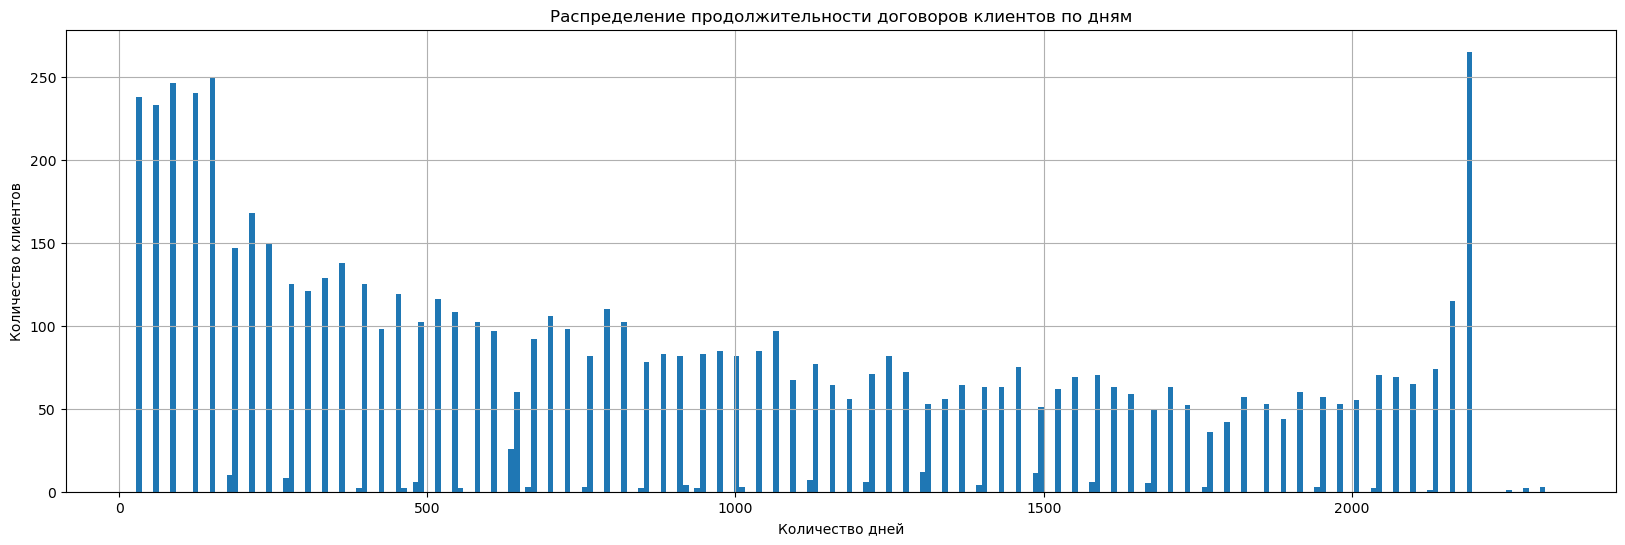

In [34]:
data['DateDiff'].plot(kind ='hist',bins=data['DateDiff'].nunique(),title ='Распределение продолжительности договоров клиентов по дням',\
                    grid =True,figsize = (20,6));#рассмотрю распределение столбца DateDiff (продолжительность договора в днях)
plt.xlabel('Количество дней');
plt.ylabel("Количество клиентов");

По графику можем заметить, что количество клиентов в первый год использования максимальное, дальше количество уменьшается. Есть один всплеск данных - 2314 дней. Возможно, клиентские условия в первый год обслуживания имеют ряд преимуществ, поэтому в начале графика заметен подъем. Максимальный пик. возможно, соответствует группе "преданных" клиентов, которые получили лучшие условия с момента основания оператора связи.  

In [35]:
#рассмотрю данные
data['Type'].value_counts()

Type
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

In [36]:
data['PaperlessBilling'].value_counts()

PaperlessBilling
Yes    4168
No     2864
Name: count, dtype: int64

In [37]:
data['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64

In [38]:
data['gender'].value_counts()

gender
Male      3549
Female    3483
Name: count, dtype: int64

In [39]:
data['SeniorCitizen'].value_counts()

SeniorCitizen
0    5890
1    1142
Name: count, dtype: int64

In [40]:
data['Partner'].value_counts()

Partner
No     3639
Yes    3393
Name: count, dtype: int64

In [41]:
data['Dependents'].value_counts()

Dependents
No     4933
Yes    2099
Name: count, dtype: int64

In [42]:
data['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2416
no_internet    1520
Name: count, dtype: int64

In [43]:
data['MultipleLines'].value_counts()

MultipleLines
No          3385
Yes         2967
no_phone     680
Name: count, dtype: int64

Построю боксплоты, чтобы наглядно посмотреть есть ли выбросы

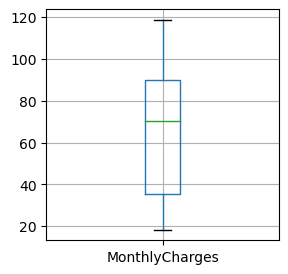

In [44]:
data.boxplot(column=['MonthlyCharges'], figsize=(3, 3));
plt.show();

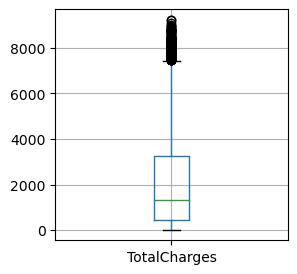

In [45]:
data.boxplot(column=['TotalCharges'], figsize=(3, 3));
plt.show();

Посмотрев столбец 'TotalCharges', я пришла к выводу, что в нем содержатся выбросы, но после анализа даты начала договора, считаю, что это старые клиенты (дата начала договора 2013-2015 год), к тому же их примерно 180, пока оставлю эти даные.

## Проверка корреляции признаков

Удалю столбец BeginDate, так как он коррелирует со столбцом DateDiff.

In [46]:
data = data.drop(['BeginDate'], axis=1)

Избавляюсь от столбца 'customerID', установливаю столбец в качестве индекса

In [47]:
data = data.set_index('customerID')
data.head()#проверка

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DateDiff
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,31
5575-GNVDE,1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123
7795-CFOCW,1,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,1371
9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,153


interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'DateDiff']


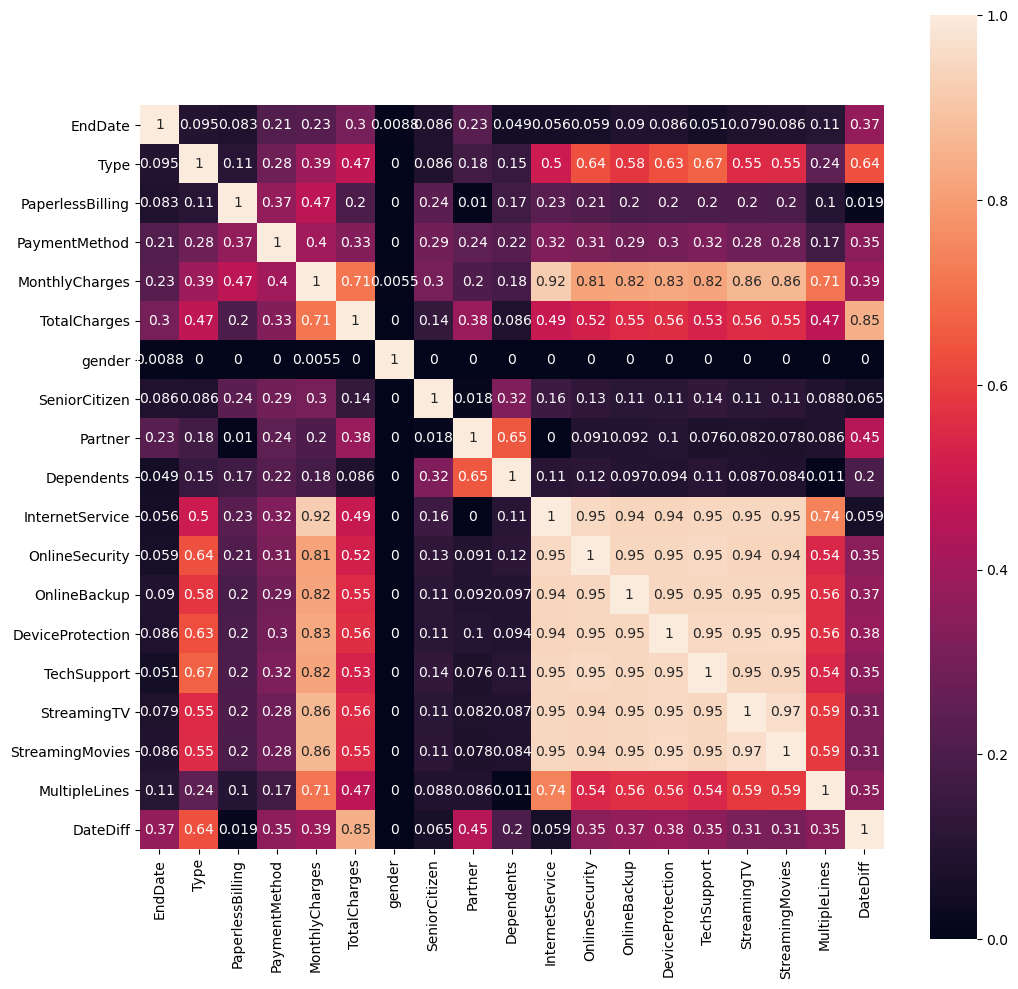

In [48]:
plt.figure(figsize=(12, 12))
sns.heatmap(data.phik_matrix(), annot=True, square=True);
plt.show()

Слабая корреляция у признака "gender" (0-0,19).

Также весьма высокая корреляция у признака "InternetService" и  "MonthlyCharges" (0,92), это весьма логично, так как обычно интернет тарифы помесячные, все интернет-услуги и помесячная оплата имеют высокую корреляцию. Телефонная услуга - многоканальность и помесячная оплата также имеют высокую корреляцию (0,71).

Весьма высокая корреляция у интернет-услуг, также считаю это логичным, скорее всего интернет-пользователи используют пакеты, в которые входит все услуги (интернет, видео, тв, техподдержка и тд). Но еще нужно вспомнить, что все пропуски я заменила заглушками, возможно это "пятно" высокой корреляции в правом нижнем углу говорит об этом.

## Исследовательский анализ данных, сравнение распределения признаков для ушедших и оставшихся клиентов

Рассмотрю распределение признаков относительно 2 групп клиентов: ушедших и оставшихся.

In [49]:
activ = data.loc[data['EndDate'] == 1]
passiv = data.loc[data['EndDate'] == 0]

Распределение клиентов по типу оплаты

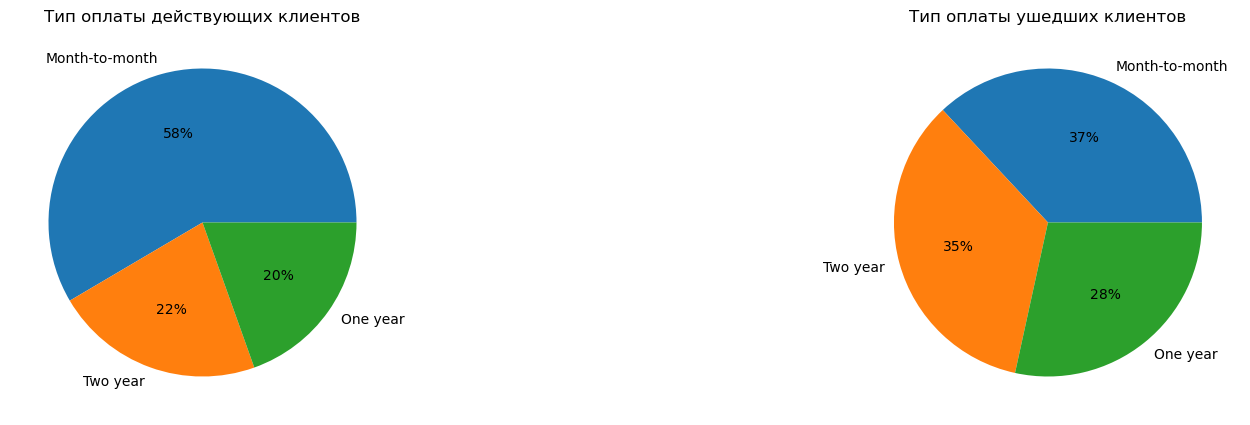

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['Type'].value_counts().plot.pie(xlabel='Type',  legend=False, label="",   title = 'Тип оплаты действующих клиентов',autopct='%1.0f%%', ax=axes[0]);
passiv['Type'].value_counts().plot.pie(xlabel='Type', rot=0, legend=False, label="", title = 'Тип оплаты ушедших клиентов',autopct='%1.0f%%', ax=axes[1]);

Распределение для действующих и ушедших клиентов схожи: 1. Помесячная оплата 2. Оплата за 2 года 3. Оплата за год

Распределение клиентов по генедеру

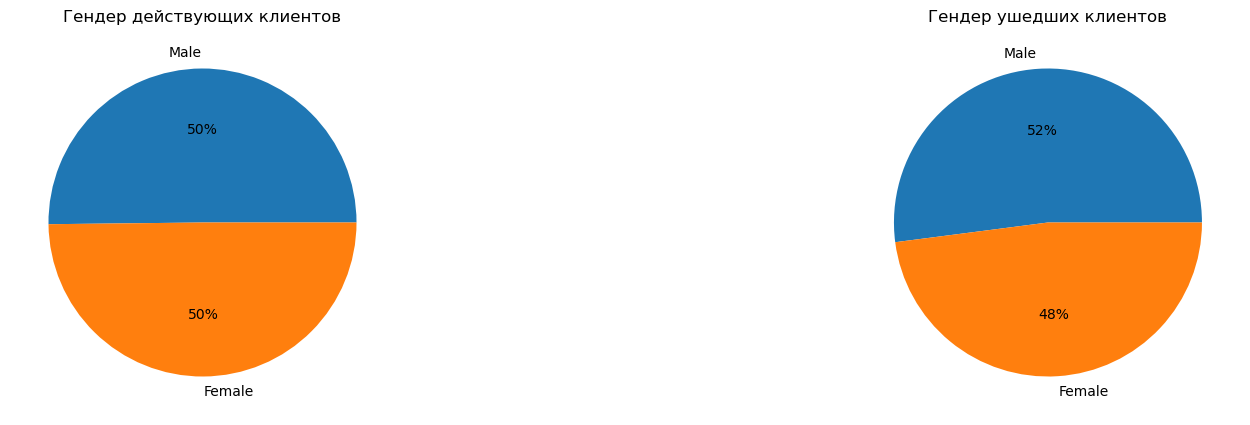

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['gender'].value_counts().plot.pie(xlabel='gender', rot=0, legend=False, label="",   title = 'Гендер действующих клиентов',autopct='%1.0f%%', ax=axes[0]);
passiv['gender'].value_counts().plot.pie(xlabel='gender', rot=0, legend=False, label="", title = 'Гендер ушедших клиентов',autopct='%1.0f%%', ax=axes[1]);

Распределения также схожи, клиенты мужчины уходят чуть чаще женщин (разница 2%).
Так как корреляция с целевым признаком нулевая, распределения ушедших и активных клиентов одинаковы, считаю, что этот признак можно удалить.

Распределение клиентов по критерию "клиент старшего возраста"

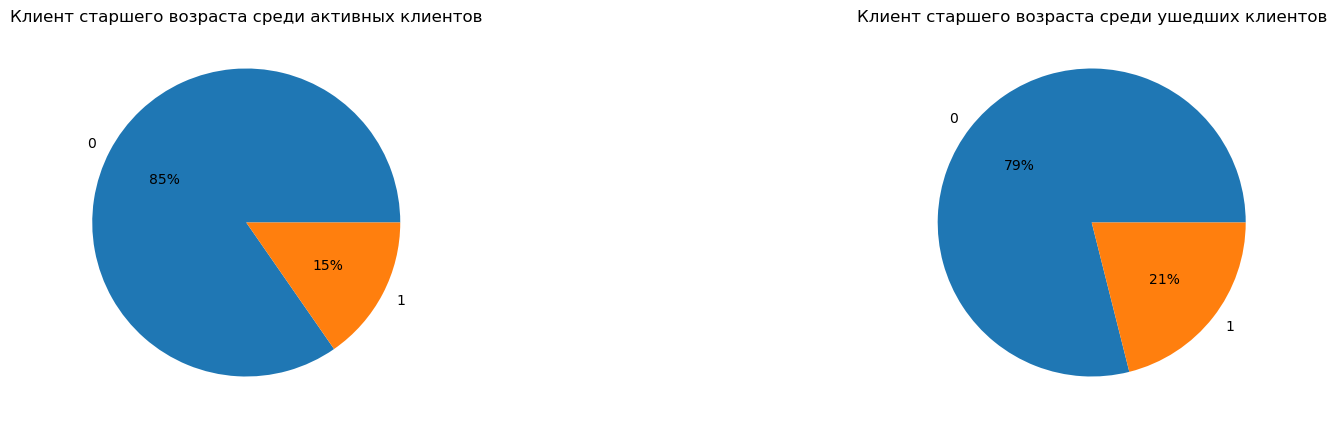

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['SeniorCitizen'].value_counts().plot.pie(xlabel='SeniorCitizen', rot=0, legend=False, label="",   title = 'Клиент старшего возраста среди активных клиентов',autopct='%1.0f%%', ax=axes[0]);
passiv['SeniorCitizen'].value_counts().plot.pie(xlabel='SeniorCitizen', rot=0, legend=False, label="", title = 'Клиент старшего возраста среди ушедших клиентов',autopct='%1.0f%%', ax=axes[1]);

Клиентов старшего возраста среди ушедших клиентов чуть больше (разница 6%).

Распределение клиентов по семейному положению

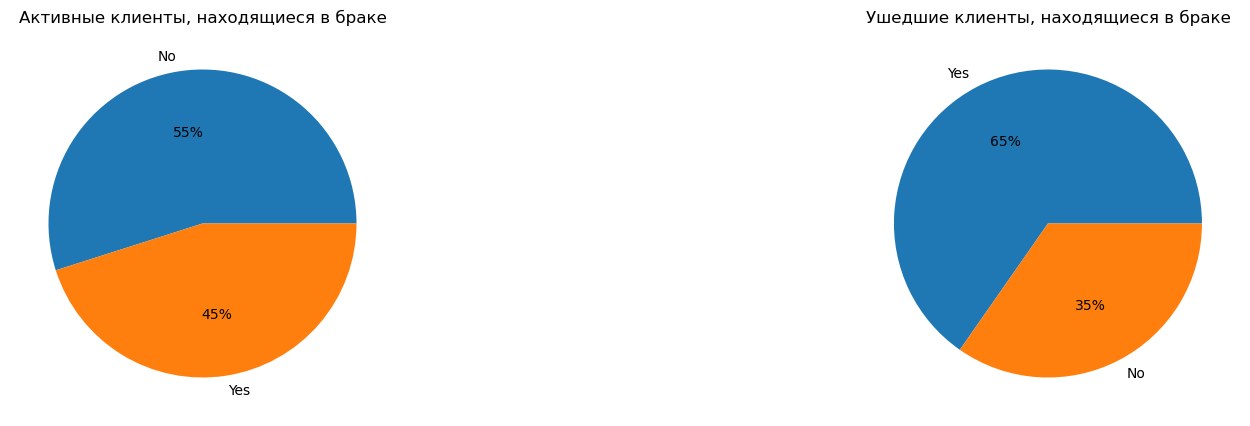

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['Partner'].value_counts().plot.pie(xlabel='Partner', rot=0, legend=False, label="",   title = 'Активные клиенты, находящиеся в браке',autopct='%1.0f%%', ax=axes[0]);
passiv['Partner'].value_counts().plot.pie(xlabel='Partner', rot=0, legend=False, label="", title = 'Ушедшие клиенты, находящиеся в браке',autopct='%1.0f%%', ax=axes[1]);

Это распределение противоположно, среди активных клиентов преимущественны одинокие клиенты, а чаще уходят клиенты, состоящие в браке.

Распределение клиентов по наличию иждивенцев

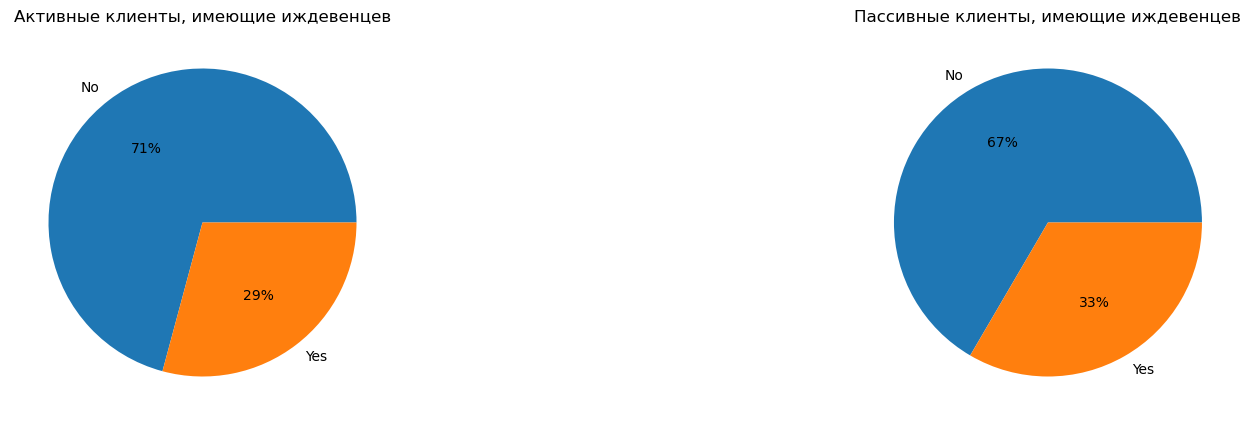

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['Dependents'].value_counts().plot.pie(xlabel='Dependents', rot=0, legend=False, label="",   title = 'Активные клиенты, имеющие иждевенцев',autopct='%1.0f%%', ax=axes[0]);
passiv['Dependents'].value_counts().plot.pie(xlabel='Dependents', rot=0, legend=False, label="", title = 'Пассивные клиенты, имеющие иждевенцев',autopct='%1.0f%%', ax=axes[1]);

Распределения очень схожи.

Распределение клиентов по типу интернет соединения

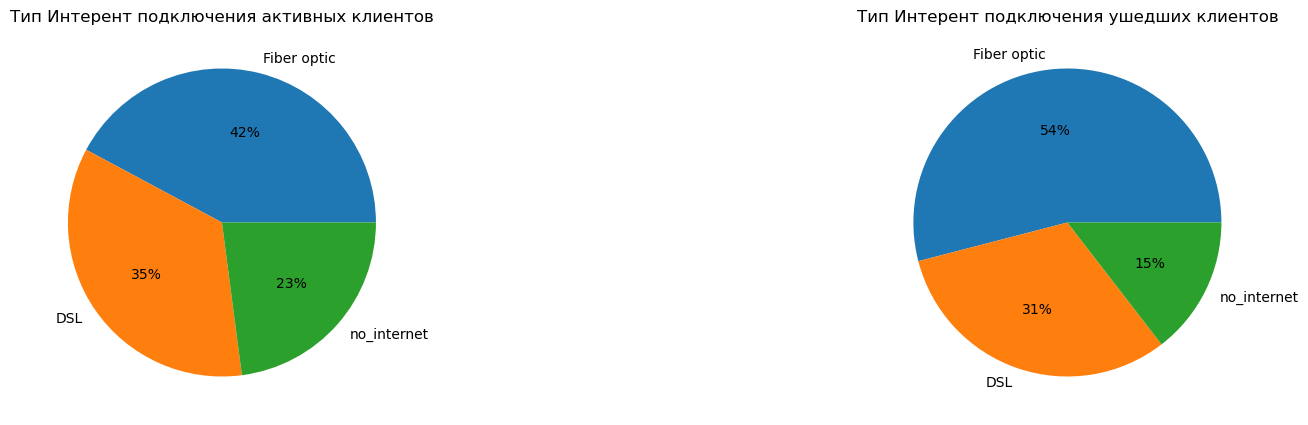

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['InternetService'].value_counts().plot.pie(xlabel='InternetService', rot=0, legend=False, label="",   title = 'Тип Интерент подключения активных клиентов',autopct='%1.0f%%', ax=axes[0]);
passiv['InternetService'].value_counts().plot.pie(xlabel='InternetService', rot=0, legend=False, label="", title = 'Тип Интерент подключения ушедших клиентов',autopct='%1.0f%%', ax=axes[1]);

Распределения схожи. Видно, что заглушка занимает значительную часть. Скорее всего этим обусловлена высокая корреляция признаков из датасета internet

Распределение клиентов по использованию стационцарной телефонной связи

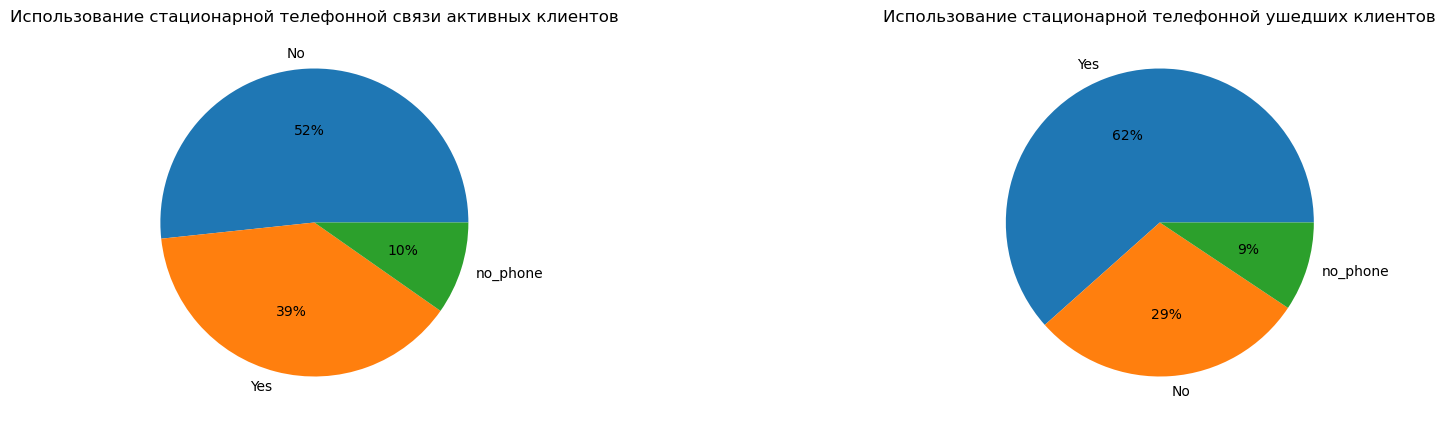

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['MultipleLines'].value_counts().plot.pie(xlabel='MultipleLines', rot=0, legend=False, label="",   title = 'Использование стационарной телефонной связи активных клиентов',autopct='%1.0f%%', ax=axes[0]);
passiv['MultipleLines'].value_counts().plot.pie(xlabel='MultipleLines', rot=0, legend=False, label="", title = 'Использование стационарной телефонной ушедших клиентов',autopct='%1.0f%%', ax=axes[1]);

Это распределение дает информацию, что половина действующих клиентов (52%) использует телефонную связь, а среди ушедших клиентов 62% пользовались данной услугой, получается клиенты были неудовлетворены услугой.

Распределение клиентов по использование стримингового телевидения

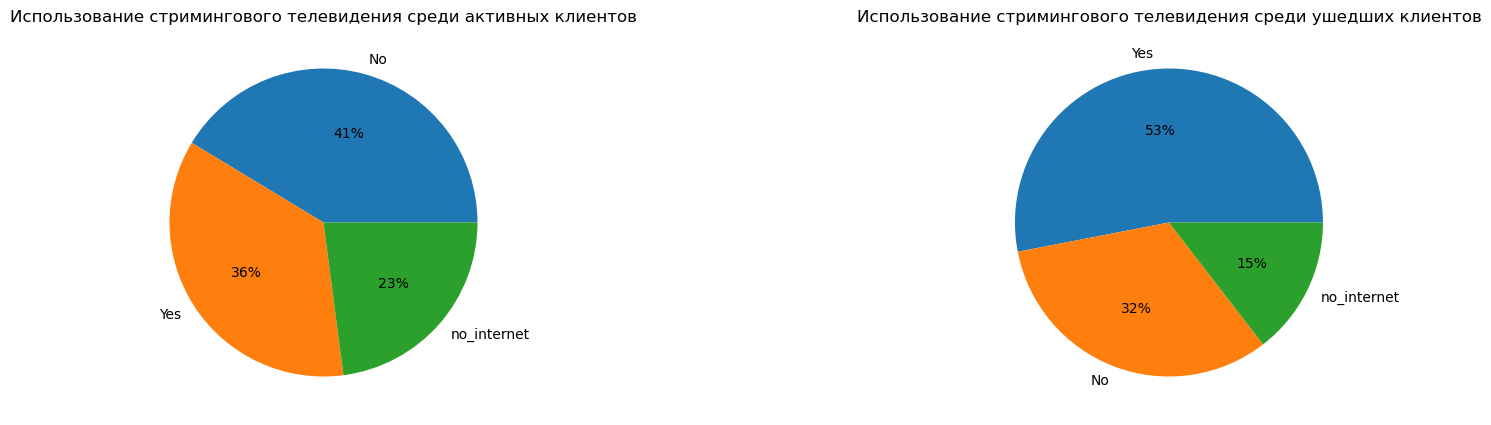

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

activ['StreamingTV'].value_counts().plot.pie(xlabel='StreamingTV', rot=0, legend=False, label="",  \
title = 'Использование стримингового телевидения среди активных клиентов',autopct='%1.0f%%', ax=axes[0]);
passiv['StreamingTV'].value_counts().plot.pie(xlabel='StreamingTV', rot=0, legend=False, label="", \
title = 'Использование стримингового телевидения среди ушедших клиентов',autopct='%1.0f%%', ax=axes[1]);

Услуга стримингового телевидения у ушедших клиентов пользовалась большим спросом, нежели у активных клиентов.

## Вывод:

Я рассмотрела некоторые распределения признаков для ушедших и оставшихся клиентов. Считаю, что признак "gender" не особо важен для дальнейшего исследования, так как распределения ушедших и активных клиентов одинаковы, а корреляция данного признака  с целевым признаком "EndDate" нулевое. 
Признаки:
-использование стримингового телевидения
-использование стационцарной телефонной связи
-семейное положение
-тип оплаты
Имеют различные распределения у ушедших и оставшихся клментов

## Исследование задачи

Целевой признак  'EndDate', распределение неравномерное. 


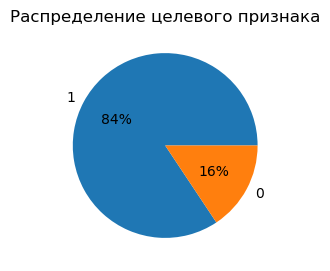

In [58]:
data['EndDate'].value_counts().plot.pie(xlabel='EndDate', label="", \
    title = 'Распределение целевого признака', figsize=(3, 3), autopct='%1.0f%%',);

Объявлю две переменные: features — признаки и target — целевой признак.

In [59]:
features = data.drop(['EndDate'], axis=1)
target = data['EndDate']
target=target.astype('int')

Разделю набор данных на обучающую (train) и  тестовую (test) выборки, stratify=target чтобы сохранить соотношение классов при разбиении.

In [60]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, \
                                                                            random_state=RANDOM_STATE, stratify=target)

In [61]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(5274, 18)

(5274,)

(1758, 18)

(1758,)

## One hot encoder для избавления от категориальных переменных

OHE применяю после разделения на выборки, чтобы не случилась утечка

In [62]:
#Сделаю OHE-кодирование
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

#Сохраню список категориальных признаков 
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
#Обучу энкодер по тренировочным данным 
encoder_ohe.fit(features_train[ohe_features])
#Добавлю закодированные признаки

features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features]) 
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])

#Удалю незакодированные категориальные признаки (изначальные колонки)

features_train = features_train.drop(ohe_features, axis=1) 
features_test = features_test.drop(ohe_features, axis=1)
features_test

C:\Users\Lubov\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,MonthlyCharges,TotalCharges,SeniorCitizen,DateDiff,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,DeviceProtection_Yes,DeviceProtection_no_internet,TechSupport_Yes,TechSupport_no_internet,StreamingTV_Yes,StreamingTV_no_internet,StreamingMovies_Yes,StreamingMovies_no_internet,MultipleLines_Yes,MultipleLines_no_phone
customerID,,,,,,,,,,,,,,,,,,,,,
0014-BMAQU,84.65,5332.95,0,1918,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0067-DKWBL,49.25,197.00,1,123,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8631-XVRZL,20.15,186.79,0,276,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
9940-HPQPG,91.75,935.85,0,306,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5299-SJCZT,101.55,507.75,0,153,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5546-QUERU,19.95,259.35,0,396,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
8008-OTEZX,19.65,687.75,0,1067,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1925-GMVBW,20.55,102.75,0,153,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## Обучение моделей

RandomForestClassifier

In [63]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE,  class_weight='balanced')
parametrs={'max_depth':[x for x in range(2, 20, 2)],
          'n_estimators': [x for x in range(10, 70, 10)]}

grid_rf = GridSearchCV(model_rf, 
                             parametrs, 
                             cv=5,
                             scoring="roc_auc")

grid_rf.fit(features_train, target_train)
best_params = grid_rf.best_params_
print(best_params)

{'max_depth': 6, 'n_estimators': 60}


In [64]:
rf_best = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, class_weight='balanced')

In [65]:
# Использую кросс-валидацию для оценки качества модели
scores = cross_val_score(rf_best, features_train, target_train, cv=5, scoring='roc_auc')
roc_auc_rf = scores.mean()
print('Среднее roc_auc по кросс-валидации:', roc_auc_rf)

Среднее roc_auc по кросс-валидации: 0.8160631411345189


LogisticRegression

Масштабирую числовые признаки

In [66]:
# Инициализация объекта scaler
scaler = StandardScaler()

# Масштабирование признаков
scaler.fit(features_train)                         # Расчет средних значений и стандартных отклонений признаков
features_train_scaled = scaler.transform(features_train)   # Применение масштабирования к обучающему набору данных

In [67]:
model_logistic=LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', class_weight='balanced')
model_logistic.fit(features_train_scaled,target_train)

LogisticRegression(class_weight='balanced', random_state=170723)

In [68]:
%%time

# использую кросс-валидацию для оценки качества модели
cv_logistic = cross_val_score(estimator=model_logistic, X=features_train_scaled, \
                                                      y=target_train, cv=5, scoring='roc_auc')
roc_auc_logistic = np.mean(cv_logistic)
print('Среднее roc_auc по кросс-валидации:', roc_auc_logistic)

Среднее roc_auc по кросс-валидации: 0.7664801762745309
CPU times: total: 672 ms
Wall time: 350 ms


CatBoostClassifier

In [69]:
%%time
 
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

model_cbc = CatBoostClassifier(class_weights=class_weights) 

parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[RANDOM_STATE], 'verbose':[False]}]

gs_cbc = GridSearchCV(model_cbc, parameters, scoring='roc_auc')
gs_cbc.fit(features_train.values, target_train.values)

print(gs_cbc.best_params_)  

{'learning_rate': 0.1, 'random_state': 170723, 'verbose': False}
CPU times: total: 5min 26s
Wall time: 1min 55s


In [70]:
%%time
#подставила лучшие параметры
model_cbc = CatBoostClassifier(**gs_cbc.best_params_, class_weights=class_weights)
model_cbc.fit(features_train.values, target_train.values)

CPU times: total: 22.9 s
Wall time: 8.66 s


In [71]:
%%time

# использую кросс-валидацию для оценки качества модели
cv_roc_auc_cbc = cross_val_score(estimator=model_cbc, X=features_train.values, \
                                                 y=target_train.values, cv=5, scoring='roc_auc')
roc_auc_cbc = np.mean(cv_roc_auc_cbc)
print('Среднее roc_auc по кросс-валидации:', roc_auc_cbc)

Среднее roc_auc по кросс-валидации: 0.9074965319084921
CPU times: total: 2min 3s
Wall time: 43 s


LGBMClassifier

In [72]:
%%time

model_LGBM = LGBMClassifier(class_weight='balanced') 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[RANDOM_STATE]}]

gsLGBM = GridSearchCV(model_LGBM, parameters, scoring='roc_auc')
gsLGBM.fit(features_train.values, target_train.values)

gsLGBM.best_params_

CPU times: total: 2min 15s
Wall time: 47.8 s


{'learning_rate': 0.3, 'num_leaves': 25, 'random_state': 170723}

In [73]:
%%time
#подставила лучшие параметры
model_LGBM = LGBMClassifier(**gsLGBM.best_params_, class_weight='balanced')
model_LGBM.fit(features_train.values, target_train.values)

CPU times: total: 922 ms
Wall time: 484 ms


LGBMClassifier(class_weight='balanced', learning_rate=0.3, num_leaves=25,
               random_state=170723)

In [74]:
%%time

# используем кросс-валидацию для оценки качества модели
roc_auc_LGBM =cross_val_score(estimator=model_LGBM, X=features_train.values, y=target_train.values, \
                                                  cv=5, scoring='roc_auc')
roc_auc_LGBM = np.mean(roc_auc_LGBM)
print('Среднее roc_auc по кросс-валидации:', roc_auc_LGBM)

Среднее roc_auc по кросс-валидации: 0.8717601399391881
CPU times: total: 4.41 s
Wall time: 2.07 s


In [75]:
#для наглядности соберу данные в сводную таблицу
index = ['Случайный лес',
         'Линейная регрессия',
         'CatBoostClassifier',
         'LGBMClassifier',
        ]

data = {'roc_auc':[roc_auc_rf,
                   roc_auc_logistic,
                   roc_auc_cbc,
                   roc_auc_LGBM]
       }

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

,roc_auc
Случайный лес,0.816063
Линейная регрессия,0.766480
CatBoostClassifier,0.907497
LGBMClassifier,0.871760


## Вывод:

В результате анализа 4 моделей, лучший результат показала модель CatBoostRegressor	среднее значение roc_auc на кросс-валидации = 0,91

## Тестирование лучшей модели

In [76]:
# Получу предсказания модели
cbc_predictions = model_cbc.predict(features_test.values)
cbc_predictions_proba = model_cbc.predict_proba(features_test.values)

# Вывод результатов
print('Catboost ROC-AUC:', roc_auc_score(target_test, cbc_predictions_proba[:, 1]))
print('Catboost Accuracy:', accuracy_score(target_test, cbc_predictions))

Catboost ROC-AUC: 0.9184184392815545
Catboost Accuracy: 0.9175199089874858


В результате проверки на тестовых данных модель Catboost показала лучшие характеристики ROC-AUC = 0.92, accuracy = 0,91.

## Исследование метрики AUC-ROC

Для наглядности построю график сравнения лучшей модели и случайной.

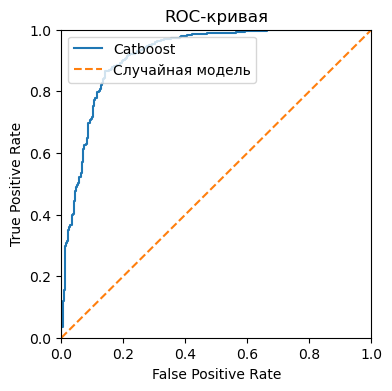

In [77]:
fpr, tpr, threshold = roc_curve(target_test.values, cbc_predictions_proba[:,1])

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')#ROC-кривая случайной модели

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Catboost', 'Случайная модель'), loc= 'upper left') 
plt.show()

При построении графика видно, что значение нашей модели ROC-AUC = 0.92 соответствует графику (площади под кривой). Показатели нашей модели значительно лучше показателей случайной модели.

In [78]:
df = pd.DataFrame(features_train.columns)
df.index = np.arange(1, len(df)+1)

df#перечень всех признаков

,0
1,MonthlyCharges
2,TotalCharges
3,SeniorCitizen
4,DateDiff
5,Type_One year
6,Type_Two year
7,PaperlessBilling_Yes
8,PaymentMethod_Credit card (automatic)
9,PaymentMethod_Electronic check
10,PaymentMethod_Mailed check


In [79]:
#Получу значимость признаков:
feature_importance = model_cbc.get_feature_importance()

# Создам список пар (индекс, значимость) для каждого признака
feature_index_importance = [(i+1, importance) for i, importance in enumerate(feature_importance)]

# Сортирую список по значимости в обратном порядке
sorted_features = sorted(feature_index_importance, key=lambda x: x[1], reverse=True)

# Распечатаю признак в отсортированном порядке
for i, importance in sorted_features:
    print("Признак {}: {:.2f}%".format(df.loc[i, 0], importance * 100))

Признак DateDiff: 4881.57%
Признак TotalCharges: 997.83%
Признак MonthlyCharges: 964.95%
Признак Type_Two year: 415.23%
Признак Partner_Yes: 296.99%
Признак Type_One year: 241.22%
Признак MultipleLines_Yes: 209.10%
Признак PaymentMethod_Mailed check: 196.10%
Признак DeviceProtection_Yes: 188.49%
Признак OnlineBackup_Yes: 175.59%
Признак Dependents_Yes: 166.85%
Признак PaperlessBilling_Yes: 151.69%
Признак gender_Male: 148.17%
Признак PaymentMethod_Credit card (automatic): 132.31%
Признак SeniorCitizen: 129.54%
Признак StreamingMovies_Yes: 119.41%
Признак PaymentMethod_Electronic check: 118.85%
Признак TechSupport_Yes: 102.78%
Признак OnlineSecurity_Yes: 99.56%
Признак MultipleLines_no_phone: 84.91%
Признак StreamingTV_Yes: 78.38%
Признак InternetService_Fiber optic: 35.69%
Признак InternetService_no_internet: 24.55%
Признак StreamingTV_no_internet: 24.24%
Признак StreamingMovies_no_internet: 4.91%
Признак DeviceProtection_no_internet: 3.91%
Признак TechSupport_no_internet: 3.11%
Призна

In [80]:
pd.set_option('display.max_columns', None)
features_train.head(3)

,MonthlyCharges,TotalCharges,SeniorCitizen,DateDiff,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_no_internet,OnlineSecurity_Yes,OnlineSecurity_no_internet,OnlineBackup_Yes,OnlineBackup_no_internet,DeviceProtection_Yes,DeviceProtection_no_internet,TechSupport_Yes,TechSupport_no_internet,StreamingTV_Yes,StreamingTV_no_internet,StreamingMovies_Yes,StreamingMovies_no_internet,MultipleLines_Yes,MultipleLines_no_phone
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3378-AJRAO,24.85,1093.4,0,1340,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7963-SHNDT,39.10,2033.2,0,1584,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7398-HPYZQ,90.55,2173.2,0,731,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


ТОП-5 значимых признаков:

    1. DateDiff
    2. TotalCharges
    3. MonthlyCharges
    4. Type_Two year
    5. Partner_Yes
    
ТОП-5 незначимых признаков:

    1. OnlineSecurity_no_internet
    2. OnlineBackup_no_internet
    3. TechSupport_no_internet
    4. DeviceProtection_no_internet
    5. StreamingMovies_no_internet	

## Вывод

В результате предобработки данных были обнаружены многочисленные пропуски в признаках датасетов internet и phone, которые в последствии я заменила на заглушки no_internet no_phone, так как пропусков больше 10%, я их не удалила для дальнейшего анализа. Если говорить о природе пропусков, то скорее всего они соответствуют тому, что клиенты не пользуются усгами интернета или стационарного телефона. Дубликаты отсутствуют.
При рассмотрении корреляции можно отметить, что признак "gender" не особо важен для дальнейшего исследования, так как распределения ушедших и активных клиентов одинаковы, а корреляция данного признака  с целевым признаком "EndDate" нулевое. 
Признаки:
-использование стримингового телевидения
-использование стационцарной телефонной связи
-семейное положение
-тип оплаты
Имеют различные распределения у ушедших и оставшихся клментов.

После рассмотрения длительности договоров, отмечу, что количество клиентов в первый год использования максимальное, дальше количество уменьшается. Есть один всплеск данных - 2314 дней. Возможно, клиентские условия в первый год обслуживания имеют ряд преимуществ, поэтому в начале графика заметен подъем. Максимальный пик, возможно, соответствует группе "преданных" клиентов, которые получили лучшие условия с момента основания оператора связи. В связи с этим, я не удалила выбросы, в связи с небольшим количеством и возможностью существования.

В результате исследования было рассмотрено 4 модели: Случайный лес, линейная регрессия, CatBoostClassifier, LGBMRClassifier с разными гиперпараметрами, оценка происходила по среднему показателю параметра ROC-AUC на сросс-валидации, выбрала лучшую - CatBoostClassifier (ROC-AUC= 0.92).

В результате проверки на тестовых данных модель CatboostClassifier показала лучшие характеристики ROC-AUC = 0.92, accuracy = 0,91.

Для наглядности был построен график сравнения ROC-кривой случайной модели и модели CatboostClassifier